   
<center>

# STROJNO UČENJE
## 2022./2023.
## Projekt - Predviđanje cijene zdravstvenog osiguranja
#### Marko Bonovil

</center>


**OPIS PROJEKTA:**
>U određivanju individualnog plana osiguranja, univerzalna metoda više nije važeća s obzirom na raznolikost načina života koji utječu na njihovo zdravlje. U tom smislu, osiguravajuća društva nastoje optimizirati pokrivenost i krajnji rezultat kako bi ponudila najbolje usluge bez prestanka poslovanja. Dakle, ova će bilježnica pokušati izgraditi prediktivni algoritam za mjerenje medicinskih troškova koje bi određeni primatelj imao za zdravstveno osiguravajuće društvo.

**Sadržaj:**


1.   Biblioteke
2.   Učitavanje podataka
3.   Preliminarna eksplorativna analiza podataka
4.   Korelacija
5.   Razdvajanje podataka
6.   Algoritmi
7.   Analiza mjerenih vrijednosti i primjer
8.   Zaključak



# 1. Biblioteke

[***Pandas***](https://pandas.pydata.org/) je Python biblioteka za manipulaciju i analizu podataka. Konkretno, nudi strukture podataka i operacije za manipuliranje numeričkim tablicama i vremenskim serijama.

[***NumPy***](https://numpy.org/doc/stable/index.html) je Python biblioteka koja dodaje podršku za velike, višedimenzionalne nizove i matrice, zajedno s velikom zbirkom matematičkih funkcija visoke razine za rad na tim nizovima.

[***Matplotlib***](https://matplotlib.org/stable/index.html) je Python biblioteka za crtanje za i numeričko matematičko proširenje NumPy.

[***Seaborn***](https://seaborn.pydata.org/#) je Python biblioteka za vizualizaciju podataka temeljena na matplotlibu. Omogućuje sučelje visoke razine za crtanje atraktivne i informativne statističke grafike.

[***sklearn***](https://scikit-learn.org/stable/) je vjerojatno najkorisnija biblioteka za strojno učenje u Pythonu. Biblioteka sklearn sadrži puno učinkovitih alata za strojno učenje i statističko modeliranje uključujući klasifikaciju, regresiju, grupiranje i smanjenje dimenzionalnosti.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# 2. Učitavanje podataka
[***Medical Cost Personal***](https://www.kaggle.com/datasets/mirichoi0218/insurance?datasetId=13720&sortBy=dateRun)

Ovaj skup podataka sastoji se od izvješća o korisnicima zdravstvenog osiguranja. Svaki zapis uključuje dob, spol, bmi koeficijent, broj djece, je li osoba pušač ili ne, regiju iz koje dolazi te iznos zdravstvenog osiguranja.

Prvi korak nam je povezati se s Google Driveom kako bi mogli učitati podatke u Google Colaboratory.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Strojno_projekt

/content/drive/MyDrive/Strojno_projekt


Nakon što smo se povezali s Google Drive, provjeravamo koliko memorije zauzima datoteka (CSV datoteka) koju ćemo koristiti za analizu. Prvo ćemo vidjeti koliko memorije imamo na raspolaganju, odnosno s čim raspolažemo u Google Colab-u, a zatim ćemo vidjeti koliko željeni skup podataka zauzima memorije kako bi znali hoćemo li paziti i poduzimati potrebne korake za rad s velikim skupom podataka (većim od dostupne memorije) te hoće li biti potrebe za unos dodatnih biblioteka za rad s velikim skupovima podataka (npr. Dask).

In [4]:
!lscpu | grep 'Model name'
!lscpu | grep '^CPU(s):' 
!lscpu | grep 'Thread(s) per core:' 
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Socket(s):'
!lscpu | grep 'CPU MHz:'

Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
CPU(s):                          2
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
CPU MHz:                         2200.136


In [5]:
!cat /proc/meminfo | grep 'MemTotal:' # ukupna kolicina memorije
!cat /proc/meminfo | grep 'MemFree:' # kolicina fizicke meorije RAM koja je ostala neiskoristena od strane sustava
!cat /proc/meminfo | grep 'MemAvailable:' # procjena koliko memorije je dostupno za novu aplikaciju bez stranicenja

MemTotal:       13297200 kB
MemFree:         7920928 kB
MemAvailable:   12382020 kB


In [6]:
#pregled koliko datoteka zauzima memorije (bash)
!ls -sh insurance.csv

55K insurance.csv


Vidimo da CSV datoteka ne zauzima mnogo memorijskog prostora, odnosno skup podataka neće zauzimati više memorije nego što imamo na raspolaganju. Iz toga možemo zaključiti da neće biti potrebe za unošenjem dodatnih biblioteka te nećemo poduzimati potrebne korake za rad s velikim skupovima podataka (većim od veličine dostupne memorije). Sada možemo učitati podatke u Pandas DataFrame (dvodimenzionalna struktura podataka - tablica koja se sastoji od redaka i stupaca).

In [7]:
insurance_dataset = pd.read_csv('/content/drive/MyDrive/Strojno_projekt/insurance.csv')

In [8]:
#iskoristenje memorije i osnovne informacije
memory_usage_efficient = insurance_dataset.memory_usage(deep=True) 
print(f"Memory usage : {memory_usage_efficient.sum()}B = {memory_usage_efficient.sum()/(1024)**2:.1f}MB")

Memory usage : 293410B = 0.3MB


In [9]:
insurance_dataset.info(memory_usage="deep") #tipovi podataka po stupcima i kolicina memorije koja se koristi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 286.5 KB


# 3. Preliminarna eksplorativna analiza podataka

U ovom poglavlju upoznat ćemo se sa strukturom podataka, semantikom podataka, nedostajućim vrijednostima itd. Nakon toga ćemo, ovisno o dobivenim rezultatima postupati, odnosno ukloniti nedostajuće vrijednosti, promijeniti tipove podataka u skupu podataka itd. Na kraju ćemo cijelu priču zaokružiti konačnim pogledom na sređene podatke.

## 3.1. Upoznavanje s podacima

### 3.1.1. Upoznavanje sa strukturom i prvi pogled na podatke

Kao prvi korak, bilo bi dobro da vidimo s koliko podataka raspolažemo (koliko stupaca i redaka sadrži skup podataka), koji su stupci, koji tipovi podataka se nalaze u stupcima te kako otprilike izgledaju vrijednosti u tim stupcima.

In [10]:
#identifikacija tipa df objekta
type(insurance_dataset)

pandas.core.frame.DataFrame

In [11]:
print(f"Ovaj skup podataka ima {insurance_dataset.shape[0]} redaka i {insurance_dataset.shape[1]} stupaca.")
print(f"Broj elemenata je: {insurance_dataset.size}")
print(f"Broj dimenzija: {insurance_dataset.ndim}")

Ovaj skup podataka ima 1338 redaka i 7 stupaca.
Broj elemenata je: 9366
Broj dimenzija: 2


In [12]:
# stupci prisutni u skupu podataka
def columns(data):
  for col in data.columns:
    print("\t",col)
print("Stupci:")
columns(insurance_dataset)

Stupci:
	 age
	 sex
	 bmi
	 children
	 smoker
	 region
	 charges


In [13]:
insurance_dataset.dtypes # tip podataka u stupcima

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [14]:
# Prikaz prvih 5 redaka skupa podataka
insurance_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Ovi podaci imaju 1338 redaka i 7 stupaca, što nas dovodi na 9366 polja ili unosa u tablicu (DataFrame). Na prvi pogled, svi stupci izgledaju pravilno označeni. Stupci su tipa ili "object"(objekt) ili "float"(decimalan broj) ili "int"(cijeli broj). Ujedno, možemo uočiti da vjerojatno ne ćemo imati posla oko NaN (nedostajućih) vrijednosti. U nastavku ćemo se malo bolje upoznati s tom problematikom.

### 3.1.2. Što predstavlja koji stupac u skupu podataka?

Upoznat ćemo se s stupcima koji se nalaze u ovom skupu podataka. Koji su to stupci, što oni predstavljaju te kakve podatke sadržavaju.

**insurance.csv:**


1.   **age**: broj godina
2.   **sex**: spol
3.   **bmi**: (Body Mass Index) indeks tjelesne mase
4.   **children**: broj djece
5.   **smoker**: konzumirali li osoba cigarete
6.   **region**: područje iz kojeg dolazi osigurana osoba
7.   **charges**: cijena koju plaća osigurana osoba



#### 3.1.2.1. NaN vrijednosti u skupu podataka

In [15]:
insurance_dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Provjerom je utvrđeno da skup podataka ne sadrži NaN vrijednosti što nam uvelike olakšava posa i daljnji rad.

#### 3.1.2.2. Stupci s vrijednostima tipa "object" i encoding

Stupce sa vrijednostima tipa "object" pretvorit ćemo u numeričke tipove pomoću [***label encodinga***](https://analyticsindiamag.com/a-complete-guide-to-categorical-data-encoding/) ili ordinal encodinga. To predstavlja postupak kategoričkog kodiranja koje se koristi kada su podaci ordinalni te se tim postupkom pretvara svaka oznaka u cjelobrojnu vrijednost, a dobiveni podaci predstavljaju niz oznaka.

In [16]:
insurance_dataset.select_dtypes(include=['object'])

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1333,male,no,northwest
1334,female,no,northeast
1335,female,no,southeast
1336,female,no,southwest


Krećemo sa stupcem "sex". U ovom stupcu nalazi se spol osigurane osobe. Vidijet cemo koji je udio pojedinog spola u ukupnom skupu podatak te primjenu categorical data encodinga odnosno pretvaranja kategoričkih podataka u numeričke.

In [17]:
insurance_dataset['sex'].unique()

array(['female', 'male'], dtype=object)

In [18]:
sex_percent=insurance_dataset['sex'].value_counts()
sex_percent

male      676
female    662
Name: sex, dtype: int64

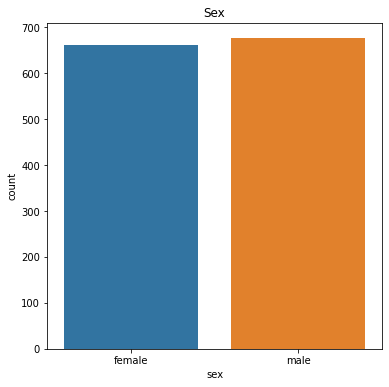

In [19]:
# Sex stupac
plt.figure(figsize=(6,6))
sns.countplot(x='sex', data=insurance_dataset)
plt.title('Sex')
plt.show()

In [20]:
print(f"Udio muškaraca u ukupnom skupu podataka je : {((sex_percent[0]/(sex_percent[0]+sex_percent)[1])*100):.2f}%")
print(f"Udio žena u ukupnom skupu podataka je : {((sex_percent[1]/(sex_percent[0]+sex_percent)[1])*100):.2f}%")

Udio muškaraca u ukupnom skupu podataka je : 50.52%
Udio žena u ukupnom skupu podataka je : 49.48%


Udio muškaraca i žena u ukupnom skupu podataka je podjednak.

U stupcu "sex" polje sa vrijednosti "male" zamjenit ćemo sa 1, a polje sa vrijednosti "female" sa 0.

In [21]:
# encoding za stupac "sex"
insurance_dataset.replace({'sex':{'male':1,'female':0}}, inplace=True)

In [22]:
print(insurance_dataset['sex'])

0       0
1       1
2       1
3       1
4       1
       ..
1333    1
1334    0
1335    0
1336    0
1337    0
Name: sex, Length: 1338, dtype: int64


Sljedeći na redu je stupac smoker koji se odnosi na to je li osigurana osoba konzumira cigarete ili ne. Ako konzumira oznaka je "yes", a ako nije oznaka je "no".

In [23]:
insurance_dataset['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [24]:
smoker_percent=insurance_dataset['smoker'].value_counts()
smoker_percent

no     1064
yes     274
Name: smoker, dtype: int64

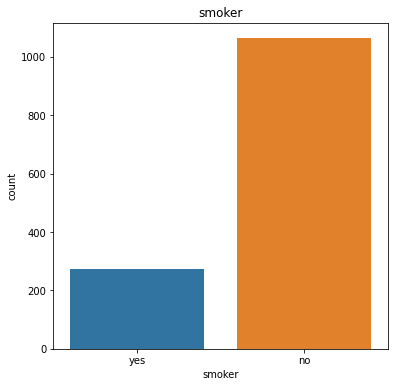

In [25]:
# Smoker stupac
plt.figure(figsize=(6,6))
sns.countplot(x='smoker', data=insurance_dataset)
plt.title('smoker')
plt.show()

In [26]:
print(f"Udio pušača u ukupnom broju osiguranih osoba je: {(smoker_percent[1]/(smoker_percent[0]+smoker_percent[1])*100):.2f}%")

Udio pušača u ukupnom broju osiguranih osoba je: 20.48%


Vidimo da je broj pušača znatno manji od broja nepušača.

U stupcu "smoker" polje sa vrijednosti "yes" zamjenit ćemo sa 1, dok polje sa vrijednosti "no" zamjenit ćemo sa 0.

In [27]:
# encoding za stupac 'smoker'
insurance_dataset.replace({'smoker':{'yes':1,'no':0}}, inplace=True)

In [28]:
print(insurance_dataset['smoker'])

0       1
1       0
2       0
3       0
4       0
       ..
1333    0
1334    0
1335    0
1336    0
1337    1
Name: smoker, Length: 1338, dtype: int64


Na kraju preostaje nam još stupac "Region" koja predstavlja područje na kojem se nalaze osigurane osobe.

In [29]:
insurance_dataset['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [30]:
region_percent=insurance_dataset['region'].value_counts()
region_percent

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

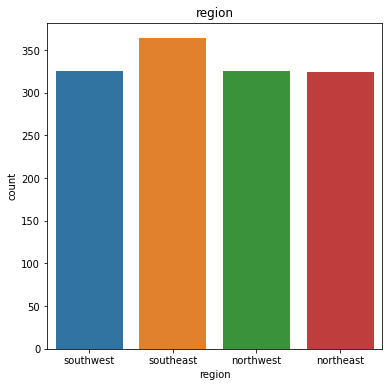

In [31]:
# Region stupac
plt.figure(figsize=(6,6))
sns.countplot(x='region', data=insurance_dataset)
plt.title('region')
plt.show()

In [32]:
print(f"Udio regije (southwest) u ukupnom broju regija: {(region_percent[1]/(region_percent[0]+region_percent[1]+region_percent[2]+region_percent[3])*100):.2f}%")
print(f"Udio regije (southeast) u ukupnom broju regija: {(region_percent[0]/(region_percent[0]+region_percent[1]+region_percent[2]+region_percent[3])*100):.2f}%")
print(f"Udio regije (northwest) u ukupnom broju regija: {(region_percent[2]/(region_percent[0]+region_percent[1]+region_percent[2]+region_percent[3])*100):.2f}%")
print(f"Udio regije (northeast) u ukupnom broju regija: {(region_percent[3]/(region_percent[0]+region_percent[1]+region_percent[2]+region_percent[3])*100):.2f}%")

Udio regije (southwest) u ukupnom broju regija: 24.29%
Udio regije (southeast) u ukupnom broju regija: 27.20%
Udio regije (northwest) u ukupnom broju regija: 24.29%
Udio regije (northeast) u ukupnom broju regija: 24.22%


Regije iz kojih dolaze osigurane osobe su poprilično podjednake.

Za stupac "region" polja sa vrijednosti "southeast" zamjenit ćemo sa vrijednosti 1, polja sa vrijednosti "southwest" sa 2, polja sa vrijednosti "northeast" sa 3, te polja sa vrijednosti "northwest" sa 4.

In [33]:
# encoding za stupac 'region'
insurance_dataset.replace({'region':{'southeast':1,'southwest':2,'northeast':3,'northwest':4}}, inplace=True)

In [34]:
print(insurance_dataset['region'])

0       2
1       1
2       1
3       4
4       4
       ..
1333    4
1334    3
1335    1
1336    2
1337    4
Name: region, Length: 1338, dtype: int64


####3.1.2.3. Stupci s vrijednostima tipa "int" i "float"

In [35]:
numerical=insurance_dataset[['age','bmi','children','charges']]
numerical

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


Kod numeričkih tipova podataka analizu započimamo sa stupcem "age" koji se odnosi na broj godina osigurane osobe. Pogledati ćemo podatke koji se nalaze u stupcu, nacrtati histogram i funkciju gustoće podataka te pomoću boxplot-a utvrditi postoje li ekstremne vrijednosti.

In [36]:
insurance_dataset['age'].unique()

array([19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, 23, 56, 27, 52, 30, 34,
       59, 63, 55, 22, 26, 35, 24, 41, 38, 36, 21, 48, 40, 58, 53, 43, 64,
       20, 61, 44, 57, 29, 45, 54, 49, 47, 51, 42, 50, 39])

In [37]:
insurance_dataset['age'].value_counts()

18    69
19    68
50    29
51    29
47    29
46    29
45    29
20    29
48    29
52    29
22    28
49    28
54    28
53    28
21    28
26    28
24    28
25    28
28    28
27    28
23    28
43    27
29    27
30    27
41    27
42    27
44    27
31    27
40    27
32    26
33    26
56    26
34    26
55    26
57    26
37    25
59    25
58    25
36    25
38    25
35    25
39    25
61    23
60    23
63    23
62    23
64    22
Name: age, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


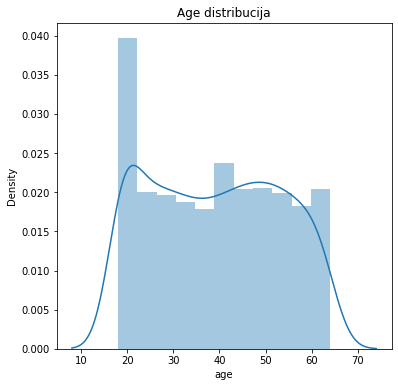

In [38]:
# Distribucija vrijednosti iz stupca 'age'
plt.figure(figsize=(6,6))
sns.distplot(insurance_dataset['age'])
plt.xlabel('age')
plt.title('Age distribucija')
plt.show()

Funkcija distplot() iz biblioteke Seaborn crta histogram uz funkciju gustoće. Za stupac "age", prema prikazanim podacima na grafu, razdioba ne naliči normalnoj ili studentovoj razdiobi. Na grafu je vidljivo da "odskaču" osobe u mlađoj životnoj dobi tj. osobe sa 18,19 i 20 godina.

In [39]:
insurance_dataset['age'].describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

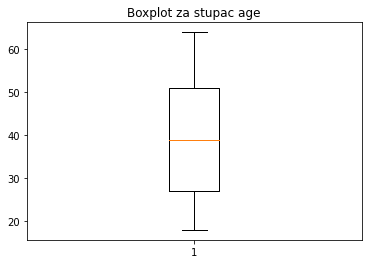

In [40]:
plt.title("Boxplot za stupac age")
plt.boxplot(insurance_dataset['age'])
plt.show()

Funkcija boxplot() iz biblioteke matplotlib crta "kutijasti dijagram". Za stupac "age" vidimo da nema ekstremnih podataka stoga neće biti potrebe za njihovim uklanjanjem.

Sljedeći stupac je "bmi" koji se odnosi na Body Mass Index odnosno predstavlja index tjelesne mase. Podatke koji se nalaze u navedenom stupcu analizirati ćemo na isti način kako smo analizirali podatke za stupac "age".

In [41]:
insurance_dataset['bmi'].unique()

array([27.9  , 33.77 , 33.   , 22.705, 28.88 , 25.74 , 33.44 , 27.74 ,
       29.83 , 25.84 , 26.22 , 26.29 , 34.4  , 39.82 , 42.13 , 24.6  ,
       30.78 , 23.845, 40.3  , 35.3  , 36.005, 32.4  , 34.1  , 31.92 ,
       28.025, 27.72 , 23.085, 32.775, 17.385, 36.3  , 35.6  , 26.315,
       28.6  , 28.31 , 36.4  , 20.425, 32.965, 20.8  , 36.67 , 39.9  ,
       26.6  , 36.63 , 21.78 , 30.8  , 37.05 , 37.3  , 38.665, 34.77 ,
       24.53 , 35.2  , 35.625, 33.63 , 28.   , 34.43 , 28.69 , 36.955,
       31.825, 31.68 , 22.88 , 37.335, 27.36 , 33.66 , 24.7  , 25.935,
       22.42 , 28.9  , 39.1  , 36.19 , 23.98 , 24.75 , 28.5  , 28.1  ,
       32.01 , 27.4  , 34.01 , 29.59 , 35.53 , 39.805, 26.885, 38.285,
       37.62 , 41.23 , 34.8  , 22.895, 31.16 , 27.2  , 26.98 , 39.49 ,
       24.795, 31.3  , 38.28 , 19.95 , 19.3  , 31.6  , 25.46 , 30.115,
       29.92 , 27.5  , 28.4  , 30.875, 27.94 , 35.09 , 29.7  , 35.72 ,
       32.205, 28.595, 49.06 , 27.17 , 23.37 , 37.1  , 23.75 , 28.975,
      

In [42]:
insurance_dataset['bmi'].value_counts()

32.300    13
28.310     9
30.495     8
30.875     8
31.350     8
          ..
46.200     1
23.800     1
44.770     1
32.120     1
30.970     1
Name: bmi, Length: 548, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


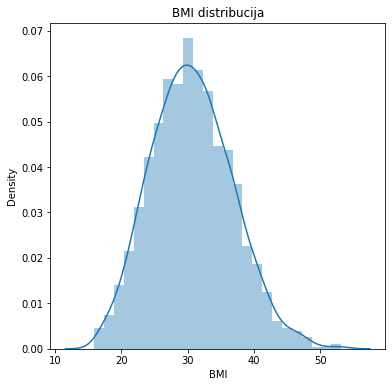

In [43]:
# Distribucija vrijednosti iz stupca 'bmi'
plt.figure(figsize=(6,6))
sns.distplot(insurance_dataset['bmi'])
plt.title('BMI distribucija')
plt.xlabel('BMI')
plt.show()

Razdioba za stupac 'bmi' sliči normalnoj ili studentovoj razdiobi odnosno simetrična je.

In [44]:
insurance_dataset['bmi'].describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

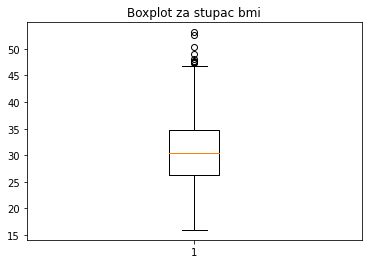

In [45]:
plt.title("Boxplot za stupac bmi")
plt.boxplot(insurance_dataset['bmi'])
plt.show()

Boxplot za stupac 'bmi' prikazuje prisutnost određenih outliera odnosno ekstremnih vrijednosti.

Sljedeći stupac kojeg analiziramo je stupac "children" koji predstavlja broj djece koju osigurana osoba ima.

In [46]:
insurance_dataset['children'].unique()

array([0, 1, 3, 2, 5, 4])

In [47]:
insurance_dataset['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

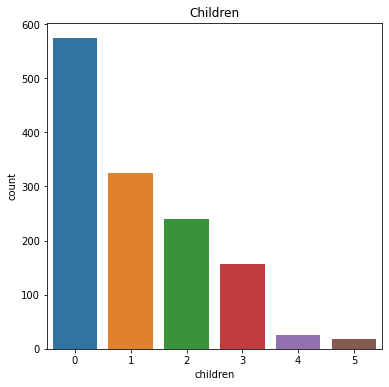

In [48]:
# children stupac
plt.figure(figsize=(6,6))
sns.countplot(x='children', data=insurance_dataset)
plt.title('Children')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


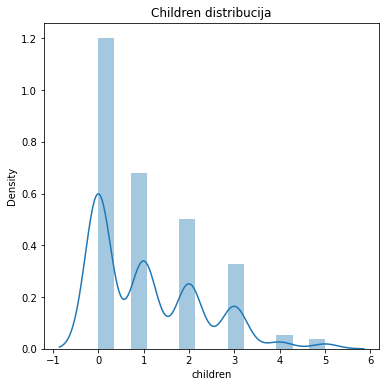

In [49]:
# Distribucija vrijednosti iz stupca 'children'
plt.figure(figsize=(6,6))
sns.distplot(insurance_dataset['children'])
plt.title('Children distribucija')
plt.xlabel('children')
plt.show()

In [50]:
insurance_dataset['children'].describe()

count    1338.000000
mean        1.094918
std         1.205493
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64

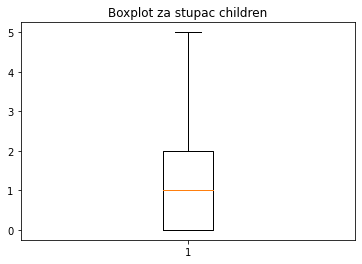

In [51]:
plt.title("Boxplot za stupac children")
plt.boxplot(insurance_dataset['children'])
plt.show()

Na posljetku analizirat ćemo stupac "charges" koji se odnosi na iznos plaćanja zdravstvenog osiguranja osiguranih osoba

In [52]:
insurance_dataset['charges'].unique()

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [53]:
insurance_dataset['charges'].value_counts()

1639.56310     2
16884.92400    1
29330.98315    1
2221.56445     1
19798.05455    1
              ..
7345.08400     1
26109.32905    1
28287.89766    1
1149.39590     1
29141.36030    1
Name: charges, Length: 1337, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


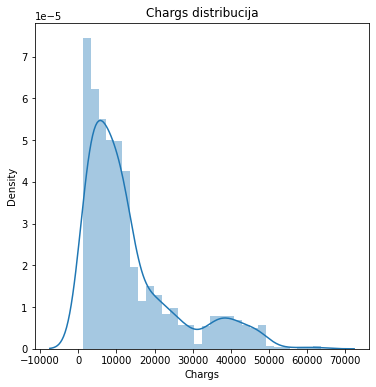

In [54]:
# Distribucija vrijednosti iz stupca 'charges'
plt.figure(figsize=(6,6))
sns.distplot(insurance_dataset['charges'])
plt.title('Chargs distribucija')
plt.xlabel('Chargs')
plt.show()

Graf nam prikazuje da je razdioba nagnuta odnosno da više ima jeftinih zdravstvenih osiguranja u odnosu na skupe, što se dalo pretpostaviti s obzirom da najviše osiguranih osoba ima u mlađoj životnoj dobi.  

In [55]:
insurance_dataset['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

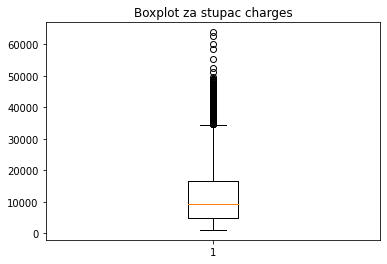

In [56]:
plt.title("Boxplot za stupac charges")
plt.boxplot(insurance_dataset['charges'])
plt.show()

Na prikazanom boxplotu može se primjetiti velika količina ekstremnih vrijednosti

In [57]:
# statistička mjerenja za cjelokupni skup podataka
insurance_dataset.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,2.455904,13270.422265
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.130888,12110.011237
min,18.000000,0.000000,15.960000,0.000000,0.000000,1.000000,1121.873900
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,3.000000,16639.912515
max,64.000000,1.000000,53.130000,5.000000,1.000000,4.000000,63770.428010


#4. Korelacija

Koristimo [corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) kako bismo dobili matricu korelacija među varijablama.Parametar method se odnosi na vrstu koeficijenta korelacije koji se koristi pri izračunu. Moguće je odabrati između 'pearson', 'spearman' ili 'kendall'. U ovom slučaju koristit ćemo person kojim provjeravamo jačinu linearne veze među varijablama.

Broj corr(X,Y) je uvijek između [-1,1]. U slučaju corr(X,Y)=+/- 1 varijable su linearno zavisne, a ako je corr(X,Y)=0 u tom slučaju kažemo da su X i Y nekorelirane.

In [58]:
corr = insurance_dataset.corr(method="pearson")
print(corr)

               age       sex       bmi  children    smoker    region   charges
age       1.000000 -0.020856  0.109272  0.042469 -0.025019  0.005212  0.299008
sex      -0.020856  1.000000  0.046371  0.017163  0.076185 -0.016121  0.057292
bmi       0.109272  0.046371  1.000000  0.012759  0.003750 -0.261829  0.198341
children  0.042469  0.017163  0.012759  1.000000  0.007673  0.019257  0.067998
smoker   -0.025019  0.076185  0.003750  0.007673  1.000000 -0.053930  0.787251
region    0.005212 -0.016121 -0.261829  0.019257 -0.053930  1.000000 -0.056993
charges   0.299008  0.057292  0.198341  0.067998  0.787251 -0.056993  1.000000


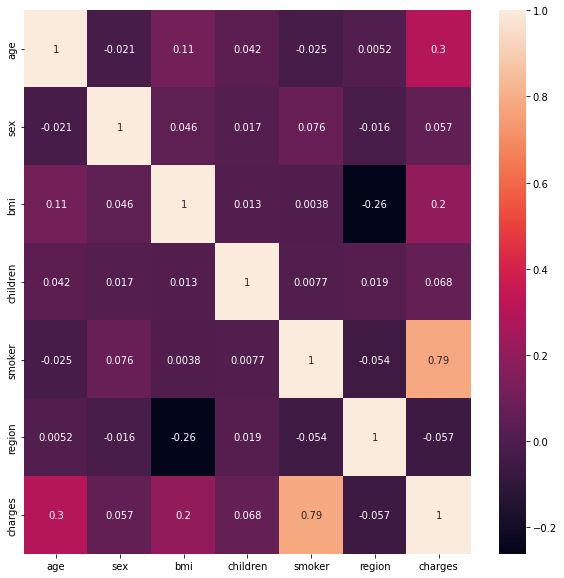

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(insurance_dataset.corr(), annot=True)

Prema prikazanoj matrici korelacije cijena zdravstvenog osiguranja najviše ovisi o tome je li osigurana osoba pušač ili ne, potom o dobi osigurane osobe i bmi koeficijentu. Dok spol, broj djece i regija iz koje dolaze imaju slab utjecaj na cijenu zdravstvenog osiguranja. Uz Pyplot možemo koristiti scatter() funkciju za crtanje dijagrama raspršenosti.

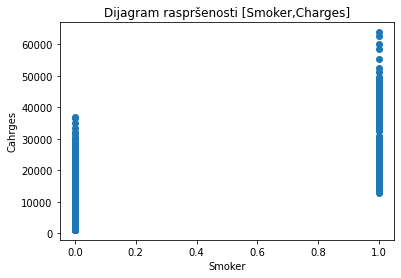

In [60]:
plt.scatter(insurance_dataset['smoker'],insurance_dataset['charges'])
plt.xlabel("Smoker")
plt.ylabel("Cahrges")
plt.title("Dijagram raspršenosti [Smoker,Charges]")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribucija cijene zdravstvenog osiguranja za ne pušače')

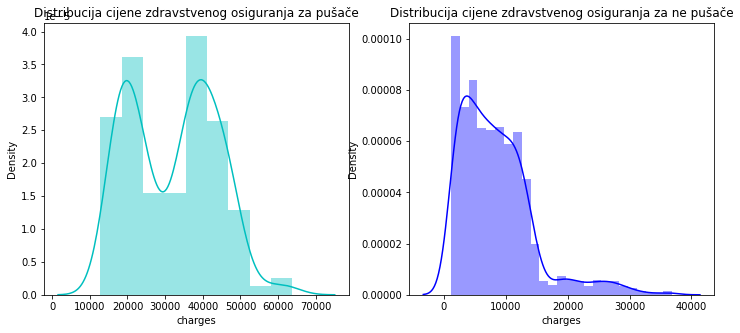

In [61]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(insurance_dataset[(insurance_dataset.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribucija cijene zdravstvenog osiguranja za pušače')

ax=f.add_subplot(122)
sns.distplot(insurance_dataset[(insurance_dataset.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribucija cijene zdravstvenog osiguranja za ne pušače')

Pušači plaćaju znatno veće zdravstveno osiguranje u odnosu na nepušače.

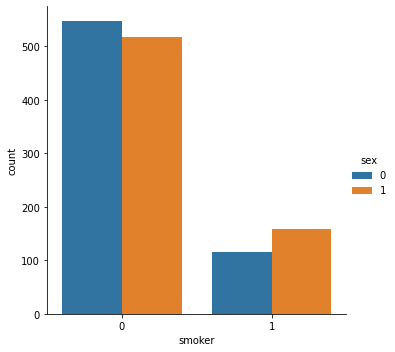

In [62]:
sns.catplot(x="smoker", kind="count",hue = 'sex', data=insurance_dataset)

Također možemo primijetiti da je više muškaraca pušača nego žena pušača. Može se pretpostaviti da će ukupni trošak liječenja kod muškaraca biti veći nego kod žena, s obzirom na utjecaj pušenja. Pogledajmo kako pušenje s brojem godina utječe na cijenu osiguranja.

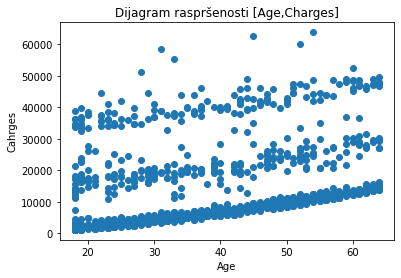

In [63]:
plt.scatter(insurance_dataset['age'],insurance_dataset['charges'])
plt.xlabel("Age")
plt.ylabel("Cahrges")
plt.title("Dijagram raspršenosti [Age,Charges]")
plt.show()

Text(0, 0.5, 'Cahrges')

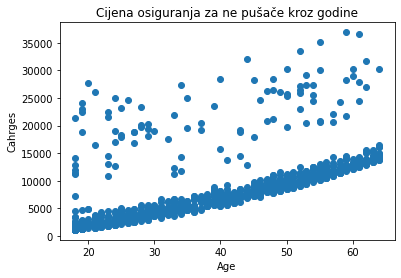

In [64]:
plt.scatter(x=insurance_dataset[(insurance_dataset.smoker == 0)].age,y=insurance_dataset[(insurance_dataset.smoker == 0)].charges)
plt.title("Cijena osiguranja za ne pušače kroz godine")
plt.xlabel("Age")
plt.ylabel("Cahrges")

Text(0, 0.5, 'Cahrges')

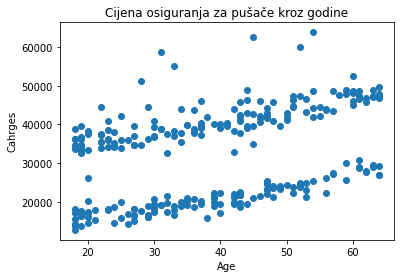

In [65]:
plt.scatter(x=insurance_dataset[(insurance_dataset.smoker == 1)].age,y=insurance_dataset[(insurance_dataset.smoker == 1)].charges)
plt.title("Cijena osiguranja za pušače kroz godine")
plt.xlabel("Age")
plt.ylabel("Cahrges")

Kod nepušača troškovi zdravstvenog osiguranja rastu s godinama. Kod pušača također vidimo takvu ovisnost samo ne baš tako vidljivu kao kod nepušača. Pogledajmo utjecaj BMI koeficijenta na cijenu zdravstvenog osiguranja. Kao što smo već vidjeli na grafu distribucije BMI koeficijenta prosječna vrijednost koeficijenta bila je 30. Pogledat ćemo kakvu cijenu plaćaju osobe sa BMI koeficijentom većim od 30, a koliko osobe sa BMI koeficijentom manjim od 30.

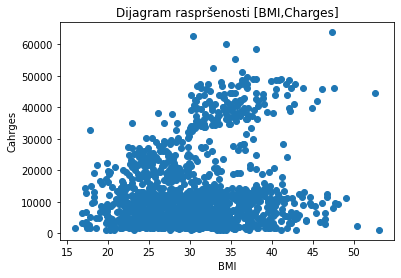

In [66]:
plt.scatter(insurance_dataset['bmi'],insurance_dataset['charges'])
plt.xlabel("BMI")
plt.ylabel("Cahrges")
plt.title("Dijagram raspršenosti [BMI,Charges]")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

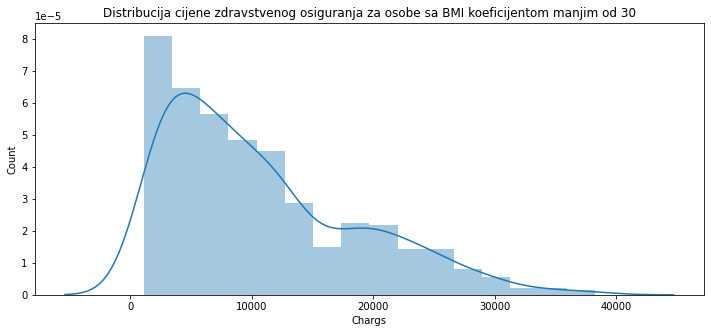

In [67]:
plt.figure(figsize=(12,5))
plt.title("Distribucija cijene zdravstvenog osiguranja za osobe sa BMI koeficijentom manjim od 30")
ax = sns.distplot(insurance_dataset[(insurance_dataset.bmi <= 30)]['charges'])
plt.xlabel('Chargs')
plt.ylabel('Count')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

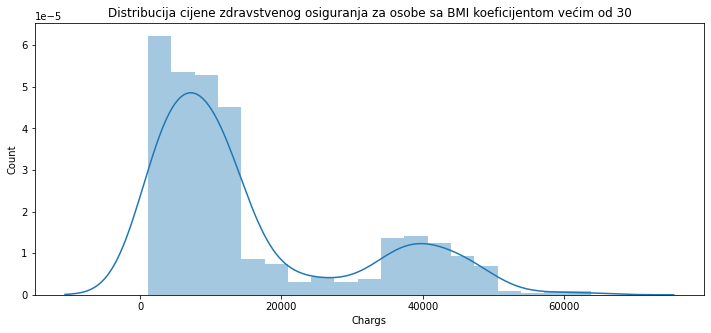

In [68]:
plt.figure(figsize=(12,5))
plt.title("Distribucija cijene zdravstvenog osiguranja za osobe sa BMI koeficijentom većim od 30")
ax = sns.distplot(insurance_dataset[(insurance_dataset.bmi >= 30)]['charges'])
plt.xlabel('Chargs')
plt.ylabel('Count')

Osobe koje imaju BMI koeficijent veći od 30 plaćaju skuplje zdravstveno osiguranje.

Text(0.5, 1.0, 'Dijagram raspršenosti [BMI,Charges]')

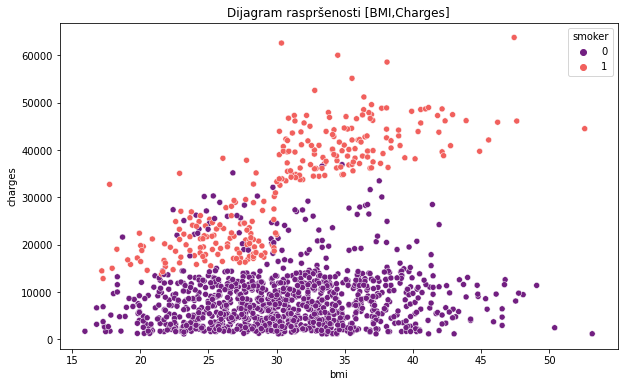

In [69]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=insurance_dataset,palette='magma',hue='smoker')
ax.set_title('Dijagram raspršenosti [BMI,Charges]')

Iz ovog dijagrama raspršenosti vidljivo je da osobe koje su pušači ali sa manjim BMI koeficijentom plaćaju manje zdravstveno osiguranje [<= 30 000] u odnosu na osobe koji su pušači sa većim BMI koeficijentom [>= 30 000].

##4.1. Vizualizacija linearnog uklapanja

Dvije funkcije koje se mogu koristiti za vizualizaciju linearnog uklapanja su [regplot()](https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot) i [Implot()](https://seaborn.pydata.org/generated/seaborn.lmplot.html#seaborn.lmplot). Obje funkcije crtaju dijagram raspršenosti dviju varijabli X i Y, a zatim uklapaju regresijski model i iscrtavaju rezultirajuću regresijsku liniju i interval pouzdanosti od 95% za tu regresiju.

Izlaz streaminga skraćen je na ovoliko posljednjih redaka: 5000.
/usr/local/lib/python3.8/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.8/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.8/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.8/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.8/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.8/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **f

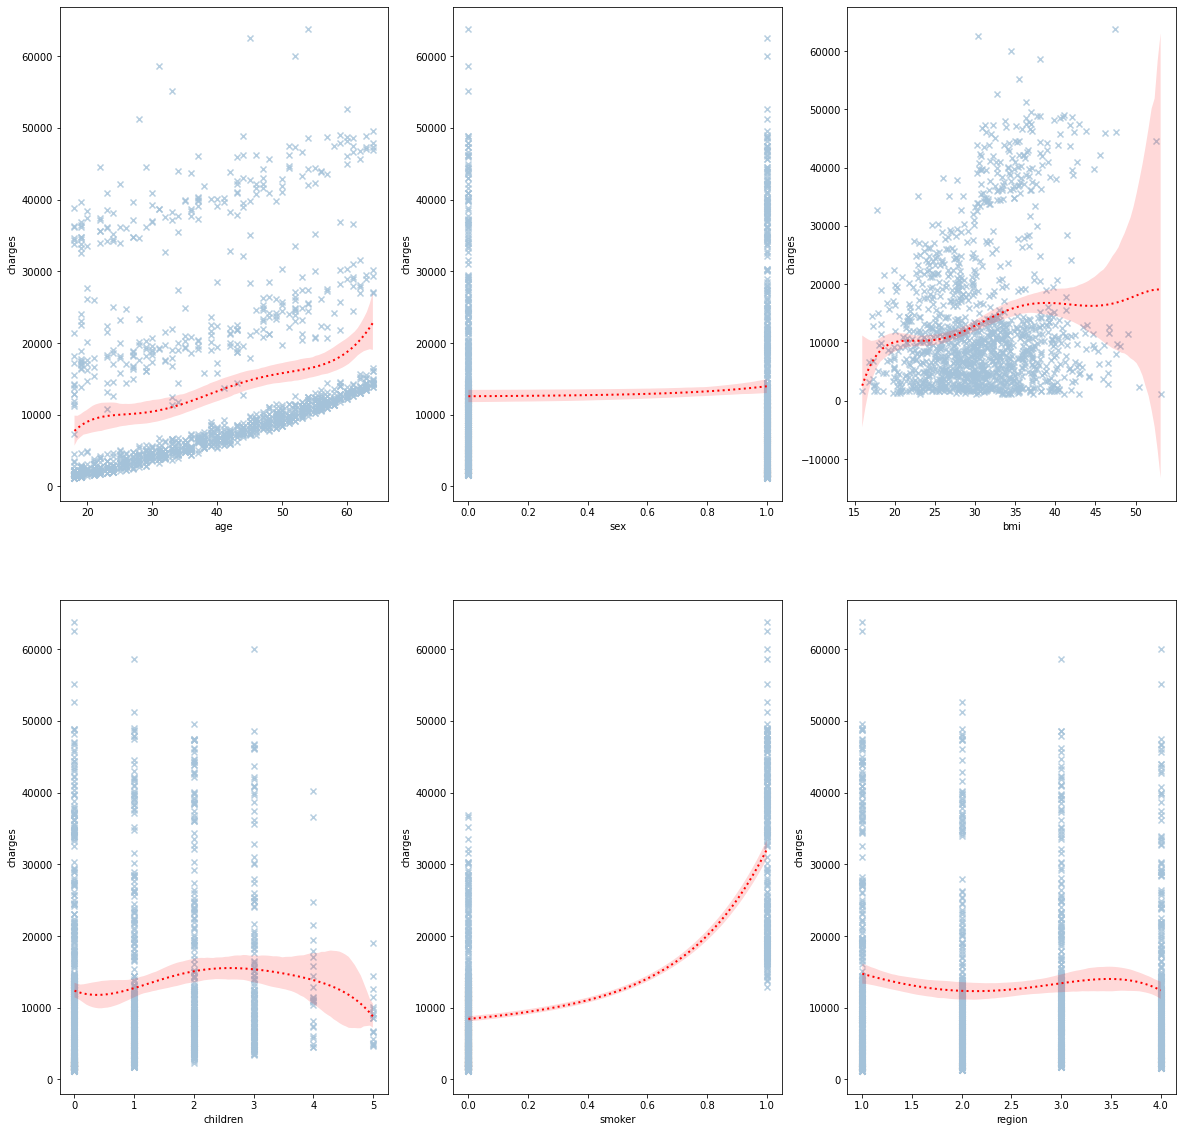

In [70]:
plt.figure(figsize=(20,20))
for idx, col in enumerate(insurance_dataset.columns, 1):
    if col == 'charges':
        continue
    plt.subplot(insurance_dataset.shape[1]-5, 3, idx)
    ax = sns.regplot(data=insurance_dataset, x=col, y='charges', marker='x', order=6, color='#A4C2D9',
                line_kws={'color':'red','linewidth':2,'linestyle':':'})
    plt.xlabel(col)

Možemo vidjeti da trend line u većini odnosa nemaju veliku zakrivljenost, što znači da linearni regresijski model može pokazati solidne rezultate.

<Figure size 1440x1440 with 0 Axes>

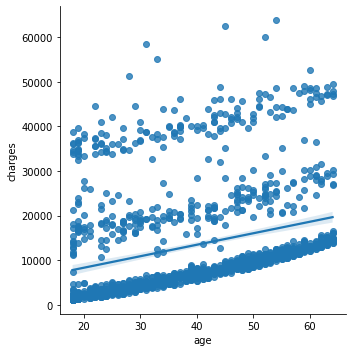

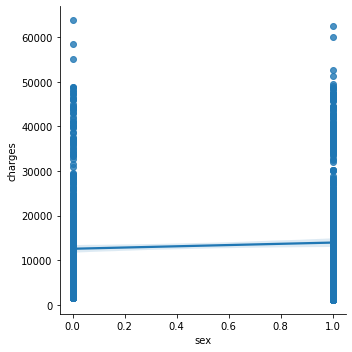

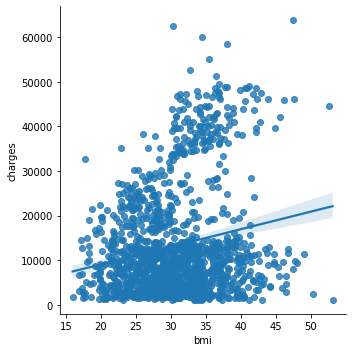

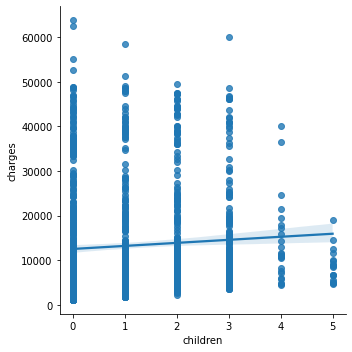

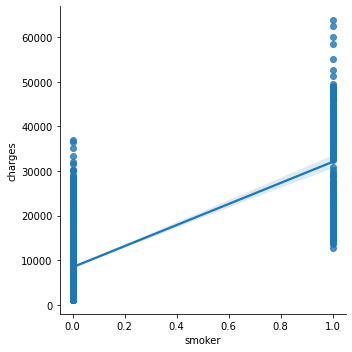

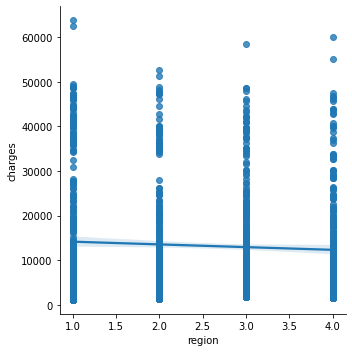

In [71]:
plt.figure(figsize=(20,20))
for idx, col in enumerate(insurance_dataset.columns, 1):
    if col == 'charges':
        continue
    ax = sns.lmplot(data=insurance_dataset, x=col, y='charges')
    plt.xlabel(col)

#5. Razdvajanje podataka

##5.1. Razdvajanje podataka na zavisne i nezavisne varijable

Prvo razdvajamo podatke na nezavisne varijable X i zavisnu varijablu Y koju predviđamo na osnovu nezavisnih varijabli. Iz skupa podataka za nezavisne varijable uzeli smo sve stupce osim stupca 'charges' kojeg predviđamo, odnosno stupca koji se nalazi u zavisnoj varijabli Y.

In [72]:
X = insurance_dataset.drop(columns=['charges'], axis=1)
Y = insurance_dataset['charges']

In [73]:
print(X)

      age  sex     bmi  children  smoker  region
0      19    0  27.900         0       1       2
1      18    1  33.770         1       0       1
2      28    1  33.000         3       0       1
3      33    1  22.705         0       0       4
4      32    1  28.880         0       0       4
...   ...  ...     ...       ...     ...     ...
1333   50    1  30.970         3       0       4
1334   18    0  31.920         0       0       3
1335   18    0  36.850         0       0       1
1336   21    0  25.800         0       0       2
1337   61    0  29.070         0       1       4

[1338 rows x 6 columns]


In [74]:
print(Y)

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64


In [75]:
insurance_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,2,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,4,21984.47061
4,32,1,28.880,0,0,4,3866.85520


##5.2. Razdvajanje podataka na podatke za treniranje i podatke za testiranje

Ulazne varijable dijelimo u 2 skupa podataka odnosno u podatke za treniranje (X_train,Y_train) i podatke za testiranje (X_test,Y_test). 80% ulaznih varijabli koristimo za treniranje modela, a preostalih 20% za testiranje. 

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [77]:
print(X.shape, X_train.shape, X_test.shape, Y.shape, Y_train.shape, Y_test.shape)

(1338, 6) (1070, 6) (268, 6) (1338,) (1070,) (268,)


#6. Algoritmi

#6.1. Linearna regresija

[Linearna regresija](https://en.wikipedia.org/wiki/Linear_regression) je model kojim se od nezavisnih varijabli $x_1, \ldots, x_n$ modelira zavisna varijabla $y$ *linearno*, odnosno gdje se zavisna varijabla $y$ pokušava prikazati kao linearna kombinacija nezavisnih varijabli uz dodatak slobodnog člana $b$: $$y = a_1 \cdot x_1 + \ldots + a_n \cdots x_n + b + \epsilon,$$
odnosno $y$ se želi prikazati kao izlaz linearne funkcije od varijabli $x_1, \ldots, x_n$.

Naravno, pošto se radi o aproksimaciji, $y$ neće biti linearna kombinacija $x_1,\ldots,x_n$ pa se zato dodaje slobodni član $\epsilon$ koji se još naziva i *greškom*.

U jednostavnoj linearnoj regresiji imamo samo 1 nezavisnu i samo 1 zavisnu varijablu pa gornja jednadžba postaje jednadžba pravca $$y = ax + b.$$

U općenitom slučaju je više zavisnih varijabli kao u prethodnoj jednadžbi. Uobičajeno se koristi matrična notacija: $$y = XA + \epsilon,$$ gdje je $y$ zavisna varijabla kao i prije, $X=(1, x_1, \ldots, x_n)$ matrica zavisnih varijabli, i $A=\begin{bmatrix}
b \\
a_1 \\
\vdots \\
a_n
\end{bmatrix}$ matrica koeficijenata.

Treniranje modela linearne regresije se svodi na problem optimizacije - smanjiti grešku aproksimacije $$\epsilon = y - XA.$$

In [78]:
# učitavanje modela linearne regresije
regressor = LinearRegression()

In [79]:
regressor.fit(X_train, Y_train)

LinearRegression()

In [80]:
# Predviđanje na podacima za treniranje
training_data_prediction =regressor.predict(X_train)
training_data_prediction

array([ 7268.83975625,  7978.77452602,  9111.244782  , ...,
       11071.02758671, 37565.49622848, 11718.673772  ])

In [81]:
# Predviđanje na podacima za testiranje
test_data_prediction =regressor.predict(X_test)
test_data_prediction

array([ 8597.28489536,  7231.74388195, 37039.23208958,  9616.21212862,
       27161.15504663, 11108.40935815,   354.21613174, 17042.35421504,
         747.16617118, 11372.94571472, 28400.38875084,  9533.99600035,
        5216.48749305, 38355.5614174 , 40201.25019476, 37046.88317993,
       15158.02888612, 35867.31947109,  9063.07424995, 31650.09572393,
        4122.46955807, 10389.18037453,  2647.70215941,  6752.0935722 ,
       11455.70143538, 12576.55372408, 14761.43409329,  6317.33228079,
        9588.04741124,  2138.14714947,  9375.87714427, 13225.72806329,
        4510.16138921,  3585.45839256,  4732.66994672, 12637.34626748,
        2260.33231947,  9078.92932601, 33459.16411947, 32548.1168527 ,
        4174.80105455,  4490.15618578, 14392.1262442 , 11588.95999023,
        8712.67197642, 12363.57345011,  5437.31098673,  3428.38801627,
       35447.7739549 ,  9084.07365487, 15767.62103266,  2302.7507234 ,
       12500.96481021,  1124.34689348, 13327.47845234, 12187.16682473,
      

In [82]:
#-------------------Regresijske_Metrike--------------------------
# R^2 (koeficijent determinacije) funkcija regresijskog rezultata
lr_score=metrics.r2_score(Y_test,test_data_prediction)
#srednja kvadratna pogreška
lr_mse=metrics.mean_squared_error(Y_test,test_data_prediction)
#srednja apsolutna pogreška
lr_mae=metrics.mean_absolute_error(Y_test, test_data_prediction)
#korijen srednje kvadratne pogreške
lr_rmse=np.sqrt(lr_mse)
#Rezultati
rezultati = pd.DataFrame([['Linearna regresija', lr_score, lr_mae, lr_mse,lr_rmse]],
                      columns=['Model', 'R-squared (R²)', 'Mean Absolute Error', 'Mean Squared Error','Square Root Mean Square Error'])


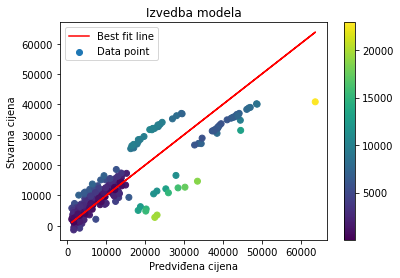

In [83]:
plt.scatter( (Y_test),(test_data_prediction),c=np.abs((Y_test)-(test_data_prediction)), label='Data point')
# Plot Best Fižt Line
plt.plot((Y_test), (Y_test),'r', label='Best fit line')
plt.xlabel('Predviđena cijena')
plt.ylabel('Stvarna cijena')
plt.title('Izvedba modela')
plt.legend()
plt.colorbar()

In [84]:
rezultati

,Model,R-squared (R²),Mean Absolute Error,Mean Squared Error,Square Root Mean Square Error
0,Linearna regresija,0.783022,4190.22019,3.368562e+07,5803.931715


##6.2.Slučajne šume

[Slučajna šuma](https://en.wikipedia.org/wiki/Random_forest) je algoritam koji je poboljšanje stabla odluke. Kako? Primjenom tzv. "uvrećavanja" (uzimamo više objekata iste vrste i "stavljamo u istu vreću" te koristimo kao jedan veliki objekt druge vrste) - eng. [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

Slučajna šuma je algoritam kod kojeg definiramo i učimo više stabala odluke te kao konačni rezultat algoritma uzimamo (težinski) prosjek rezultata svih stabala. Prosjek za slučaje klasifikacije je kategorička sredina - mod, a za slučaje regresije je numerička sredina - aritmetička sredina.

Slučajna šuma je primjer tzv. [metoda ansambla](https://en.wikipedia.org/wiki/Ensemble_learning) - kolekcije više algoritama koji sami mogu riješiti problem, a koje tretiramo kao jedan unificirani algoritam.

In [85]:
from sklearn.ensemble import RandomForestRegressor

In [86]:
rfr=RandomForestRegressor(n_estimators=10, random_state=42)
rfr.fit(X_train,Y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [87]:
rfr_y_pred = rfr.predict(X_test)
rfr_mse = metrics.mean_squared_error(Y_test, rfr_y_pred)
rfr_mae = metrics.mean_absolute_error(Y_test, rfr_y_pred)
rfr_score = metrics.r2_score(Y_test, rfr_y_pred)
rfr_rmse = np.sqrt(rfr_mse)

In [88]:
rfr_y_pred

array([ 8401.32707   ,  5066.802265  , 28244.10081   , 11083.691695  ,
       34598.967486  ,  7487.001043  ,  2159.517325  , 14298.43054   ,
        3341.515845  , 10241.51763   , 20470.291019  ,  8771.488325  ,
        5252.984365  , 46976.044582  , 49043.092333  , 45876.272975  ,
        9795.71858   , 42585.806821  ,  8184.38098   , 25246.409389  ,
        8113.732047  , 10629.899525  ,  2878.704446  ,  2349.878595  ,
       12150.600896  , 11737.198426  , 12681.72012   ,  6502.455384  ,
        8982.2667    ,  6986.54147083,  7725.985735  , 11914.799155  ,
        5230.714821  ,  6375.66458   ,  2947.39461   ,  9787.241538  ,
        2347.1036    ,  7408.04734   , 24167.128735  , 38815.39467   ,
        4553.20997   ,  2367.246505  , 11668.230805  , 15607.510504  ,
        6256.498927  , 14416.670483  , 16757.641834  ,  7709.847044  ,
       42123.385871  , 10177.368088  , 13940.47999   ,  2783.749009  ,
        6908.670735  ,  1708.42396   , 12327.664827  ,  9612.94424   ,
      

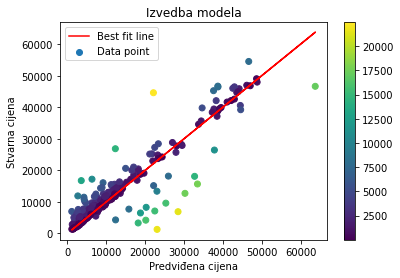

In [89]:
#Rezultati 
rfr_rezultati = pd.DataFrame([['Slučajne šume', rfr_score, rfr_mae, rfr_mse,rfr_rmse]],
                      columns=['Model', 'R-squared (R²)', 'Mean Absolute Error', 'Mean Squared Error','Square Root Mean Square Error'])

rezultati = rezultati.append(rfr_rezultati, ignore_index=True)
plt.scatter((Y_test),(rfr_y_pred), c=np.abs((Y_test)-(rfr_y_pred)), cmap='viridis', label='Data point')
# najbolja linija
plt.plot((Y_test), (Y_test), 'r', label='Best fit line')
plt.xlabel('Predviđena cijena')
plt.ylabel('Stvarna cijena')
plt.title('Izvedba modela')
plt.legend()
plt.colorbar()

In [90]:
rfr_rezultati

,Model,R-squared (R²),Mean Absolute Error,Mean Squared Error,Square Root Mean Square Error
0,Slučajne šume,0.850536,2609.735748,2.320408e+07,4817.06119


#6.3. Stabla odluke

[Stablo odluke](https://en.wikipedia.org/wiki/Decision_tree_learning) je algoritam nadziranog učenja kojim se može vršiti zadatak klasifikacije ili regresije. Odnosno o zadatku, govorimo o klasifikacijskom stablu ili regresijskom stablu odluke.U projektu je korišteno [regresijsko stablo odluke](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor).

In [91]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()

In [92]:
dtr.fit(X_train,Y_train)

DecisionTreeRegressor()

In [93]:
dtr_y_pred = dtr.predict(X_test)
dtr_mse = metrics.mean_squared_error(Y_test, dtr_y_pred)
dtr_mae = metrics.mean_absolute_error(Y_test, dtr_y_pred)
dtr_score = metrics.r2_score(Y_test, dtr_y_pred)
dtr_rmse = np.sqrt(dtr_mse)

In [94]:
dtr_y_pred

array([ 7325.0482  ,  5469.0066  , 28950.4692  ,  9225.2564  ,
       33732.6867  , 11326.71487 ,  2527.81865 , 14410.9321  ,
        3378.91    , 11015.1747  , 19361.9988  ,  6986.697   ,
        4040.55825 , 45702.02235 , 48173.361   , 48885.13561 ,
        9304.7019  , 41676.0811  , 10702.6424  , 21348.706   ,
        3906.127   ,  6849.026   ,  2128.43105 ,  1984.4533  ,
       10493.9458  , 11512.405   , 13228.84695 ,  5312.16985 ,
        9447.25035 ,  1712.227   ,  7954.517   , 11353.2276  ,
       11482.63485 ,  4906.40965 ,  3490.5491  ,  9704.66805 ,
        2585.269   ,  8522.003   , 24869.8368  , 37742.5757  ,
        4830.63    ,  2639.0429  , 10713.644   , 12323.936   ,
        5124.1887  , 12925.886   , 26018.95052 ,  3906.127   ,
       40273.6455  ,  4949.7587  , 13887.9685  ,  1720.3537  ,
        6393.60345 ,  1708.0014  , 20781.48892 , 10600.5483  ,
        3070.8087  , 58571.07448 , 11362.755   , 11512.405   ,
       13462.52    ,  4340.4409  , 15170.069   ,  7729.

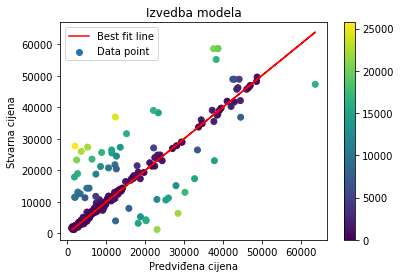

In [95]:
dtr_rezultati = pd.DataFrame([['Stabla odluke', dtr_score, dtr_mae, dtr_mse, dtr_rmse]],
                      columns=['Model', 'R-squared (R²)', 'Mean Absolute Error', 'Mean Squared Error','Square Root Mean Square Error'])

rezultati = rezultati.append(dtr_rezultati, ignore_index=True)
plt.scatter((Y_test),(dtr_y_pred), c=np.abs((Y_test)-(dtr_y_pred)), cmap='viridis', label='Data point')
# Najbolja linija
plt.plot((Y_test), (Y_test), 'r', label='Best fit line')
plt.xlabel('Predviđena cijena')
plt.ylabel('Stvarna cijena')
plt.title('Izvedba modela')
plt.legend()
plt.colorbar()

In [96]:
dtr_rezultati

,Model,R-squared (R²),Mean Absolute Error,Mean Squared Error,Square Root Mean Square Error
0,Stabla odluke,0.705981,3266.018886,4.564608e+07,6756.187946


#7. Analiza mjerenih vrijednosti i primjer

In [97]:
rezultati

,Model,R-squared (R²),Mean Absolute Error,Mean Squared Error,Square Root Mean Square Error
0,Linearna regresija,0.783022,4190.220190,3.368562e+07,5803.931715
1,Slučajne šume,0.850536,2609.735748,2.320408e+07,4817.061190
2,Stabla odluke,0.705981,3266.018886,4.564608e+07,6756.187946


In [98]:
print(f"r2 vrijednost:\n {rezultati[['Model','R-squared (R²)']]}")
print("-------------------------------------------------------------------------")
print(f"srednja kvadratna pogreška:\n {rezultati[['Model','Mean Squared Error']]}")
print("-------------------------------------------------------------------------")
print(f"srednja apsolutna pogreška:\n {rezultati[['Model','Mean Absolute Error']]}")
print("-------------------------------------------------------------------------")
print(f"korijen srednje kvadratne pogreške:\n {rezultati[['Model','Square Root Mean Square Error']]}")
print("-------------------------------------------------------------------------")

r2 vrijednost:
                 Model  R-squared (R²)
0  Linearna regresija        0.783022
1       Slučajne šume        0.850536
2       Stabla odluke        0.705981
-------------------------------------------------------------------------
srednja kvadratna pogreška:
                 Model  Mean Squared Error
0  Linearna regresija        3.368562e+07
1       Slučajne šume        2.320408e+07
2       Stabla odluke        4.564608e+07
-------------------------------------------------------------------------
srednja apsolutna pogreška:
                 Model  Mean Absolute Error
0  Linearna regresija          4190.220190
1       Slučajne šume          2609.735748
2       Stabla odluke          3266.018886
-------------------------------------------------------------------------
korijen srednje kvadratne pogreške:
                 Model  Square Root Mean Square Error
0  Linearna regresija                    5803.931715
1       Slučajne šume                    4817.061190
2       Stabla o

In [99]:
#input_data = (age,sex,bmi,children,smoker,region)
input_data = (31,1,25.74,0,1,0)
#promjena ulaznih podataka u array
input_data_as_numpy_array = np.asarray(input_data)

#reshape array
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)
#predikcija
prediction1 = regressor.predict(input_data_reshaped)
prediction2 = rfr.predict(input_data_reshaped)
prediction3 = dtr.predict(input_data_reshaped)

print(f'Cijena zdravstvenog osiguranja [LR]: {prediction1[0]:.2f}$')
print(f'Cijena zdravstvenog osiguranja [RF]: {prediction2[0]:.2f}$')
print(f'Cijena zdravstvenog osiguranja [DT]: {prediction3[0]:.2f}$')

Cijena zdravstvenog osiguranja [LR]: 27506.55$
Cijena zdravstvenog osiguranja [RF]: 19092.23$
Cijena zdravstvenog osiguranja [DT]: 17496.31$


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


#8. Zaključak

* Pušenje je najveći čimbenik koji utječe na cijenu zdravstvenog osiguranja, a slijede ga dob i indeks tjelesne mase.
* Trošak osiguranja nepušača manji je od troška osiguranja pušača.
* Što je viša dob, to je veća vrijednost troška osiguranja.
* Pušenje u kombinaciji s indeksom tjelesne mase daje vidljivu razliku u cijeni zdravstvenog osiguranja
* Regionalne razlike i spol nemaju značajan utjecaj na troškove osiguranja.